In this notebook we will be doing the following tasks:
1.   Define a small convolutional neural network and train in on MNIST digit dataset (as a classification task).
2.   (Bonus) Take the trained network, freeze all of its weights and learn the image which gives the output of a particular digit. (This will be defined better, when we reach that task).
3.   (Bonus) Try the same on a different dataset (like MNIST fashion dataset).
4.   (Bonus) Try to formulate the MNIST classification problem as a regression problem instead. (i.e. Have 1 output unit which outputs a floating point value and you round it off to obtain the digit.)

In [39]:
## Imports

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import numpy as np
from matplotlib import pyplot as plt

# Using GPU
device = 'cuda' #Change this to 'cpu' to run on cpu. 

Here we will download the MNIST digit dataset and convert it into PyTorch dataset object. 

torchvision module of PyTorch provides several Computer Vision specific functionalities one of which is easy importing of several [popular datasets](https://pytorch.org/docs/stable/torchvision/datasets.html). 

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


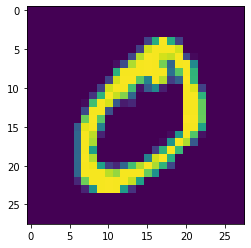

In [40]:
#Loading the MNIST dataset here.

#This creates a transform object which will be passed to the later functions. It converts the training image from PIL Image objects to PyTorch image objects.
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform )

test_data = torchvision.datasets.MNIST(root = './data',train = False ,download = True,  transform = transform)

print(train_data)
print(test_data)

plt.imshow(np.asarray(train_data[1][0].reshape(28,28)))

The following cell converts the DataSet objects to DataLoader objects. 
DataLoader objects in PyTorch provide several useful functionalities, such as automatic batching, parallel data processing on the CPU, etc. Therefore it is generally advisable to use dataloader instead of manually handling data. 

Read more about PyTorch DataSet and DataLoader [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [41]:
#BATCHs are only used for training, while testing we conventionally use a batch size of 1.  
BATCH_SIZE = 32 
train_loader = torch.utils.data.DataLoader (train_data, batch_size = BATCH_SIZE, )
test_loader = torch.utils.data.DataLoader (test_data, batch_size = 1, )

print(train_loader)

**TASK 1**

We will define our network in the following cell. There are several ways of doing this in PyTorch, but in this example we will do it by subclassing nn.module. You should be able to do this after reading the tutorials given at the top of the page. [This](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) is extra reading to help you out. (Do remember that we are dealing with 1 channel B/W images not 3 channels colour images.)

[Here](https://pytorch.org/docs/stable/nn.html) are official docs of nn module to help you out. 

Our network will have 4 convolutional layers followed by 2 fully-connected layers. (You free to change make slight changes to this but don't make the network too deep in the final submission). 

Don't forget to have ReLU activations and maxpooling layers.

Experiment with different kernal sizes, width and sizes of hidden fully connected units. 


In [42]:
class MyConvNet(nn.Module):
    def __init__(self):
        """ 
          Initializes all the weights for each layer
        """ 

        super(MyConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 128, kernel_size=5)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=5)
        self.conv3 = nn.Conv2d(64,32, kernel_size=3)
        self.conv4 = nn.Conv2d(32,16, kernel_size=3)

        self.fc1 = nn.Linear(8 * 8 * 1, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward (self, x):
        """
        Defines a forward pass for the given network. x is a 4 dimentional input tensor. 
        Input: x.size() = [BATCH_SIZE, 1, 28, 28]

        Returns a 2-dimentional, 10-unit output tensor representing the probability. 
        Output: x.size() = [BATCH_SIZE, 10] 
        """

        x = F.relu(self.conv1(x))

        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        x = F.relu(F.max_pool2d(self.conv3(x),2))

        x = F.relu(F.max_pool2d(self.conv4(x),1))

        x = x.view(-1,8*8*1 )

        x = F.relu(self.fc1(x))

        x = self.fc2(x)

        #Return softmax of x, so no activation.
        return F.softmax(x, dim = 1) 


The following cell will instantiate the the network we defined above.
Check the size of the output tensor (it should be [BATCH_SIZE, 10]) and see if the values in the output tensor printed below are numbers between 0 and 1. (Infact most values should be close to 0.1. Why?)

In [43]:
#Setting few things up.

net = MyConvNet()
net.cuda()
net.to(device)
print(net)
tld = iter(train_loader)
im = next(tld)[0].to(device)
print ('Size of the output tensor:' ,net.forward(im).size())
print (net.forward(im))

MyConvNet(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Size of the output tensor: torch.Size([32, 10])
tensor([[0.1018, 0.0968, 0.0995, 0.1031, 0.0987, 0.1059, 0.0999, 0.1024, 0.0941,
         0.0977],
        [0.1018, 0.0968, 0.0993, 0.1031, 0.0987, 0.1059, 0.1003, 0.1023, 0.0940,
         0.0978],
        [0.1018, 0.0970, 0.0993, 0.1031, 0.0985, 0.1060, 0.1001, 0.1022, 0.0940,
         0.0979],
        [0.1017, 0.0969, 0.0994, 0.1031, 0.0987, 0.1059, 0.1002, 0.1021, 0.0940,
         0.0979],
        [0.1019, 0.0970, 0.0996, 0.1029, 0.0986, 0.1059, 0.1001, 0.1023, 0.0940,
         0.0977],
        [0.1018, 0.0970, 0.0994, 0.1030, 0.0986, 0.1059, 0.1000, 0.1024, 0.09

The following cell will define the training and the testing loop. 

In [44]:
def train(model, train_loader, EPOCHS = 6, lossF = None):
  
    if lossF == None:
        lossF = nn.CrossEntropyLoss() #Cross entropy loss is popularly used for classification tasks. 

    ## It is not very sensitive to hyperparameters and therefore it becomes a natural choice in quick experiments.
    optim = torch.optim.Adam (model.parameters(), lr = 4e-4, weight_decay=1e-3) 

    model.train() #Changes the model to train mode. All the require_grad are set to true.

    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):

            #Move data to device
            var_X_batch = Variable(X_batch).to(device) 
            var_y_batch = Variable(y_batch).to(device)

            ## Forward Pass
            output = model(var_X_batch)

            ## Calculate the loss incurred
            loss = lossF (output, var_y_batch)

            ## BackProp: Computes all gradients.
            loss.backward()

            ## Gradient Descent Step (Adam)
            optim.step()
            optim.zero_grad() # This is important because PyTorch keeps on adding to the original value of gradient.

            ## Gets the predictions. From probablities (the digit with highest probablity is the prediction) 
            predicted = torch.max(output.data, axis = 1).indices

            ## Calculates the number of correct predictions in a batch
            correct += (predicted == var_y_batch).sum()

            if (batch_idx % 200) == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                        epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item(), float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))



def test(model, test_loader):

    correct = 0 
    
    for test_imgs, test_labels in test_loader:
        
        test_imgs = Variable(test_imgs).float()
        test_imgs = Variable(test_imgs).to(device) 
        test_labels = Variable(test_labels).to(device) 
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    
    
    print("Test accuracy:{:.3f}% ".format( float(correct * 100) / (len(test_loader))))



Running the following cell will start training of the "net". 

In [45]:
net = net.cuda()
train (net, train_loader, EPOCHS = 20)

Epoch : 0 [0/60000 (0%)]	Loss: 2.302924	 Accuracy:6.250%
Epoch : 0 [6400/60000 (11%)]	Loss: 1.809807	 Accuracy:57.898%
Epoch : 0 [12800/60000 (21%)]	Loss: 1.744345	 Accuracy:65.983%
Epoch : 0 [19200/60000 (32%)]	Loss: 1.730702	 Accuracy:69.228%
Epoch : 0 [25600/60000 (43%)]	Loss: 1.644107	 Accuracy:72.940%
Epoch : 0 [32000/60000 (53%)]	Loss: 1.585843	 Accuracy:76.049%
Epoch : 0 [38400/60000 (64%)]	Loss: 1.554121	 Accuracy:78.877%
Epoch : 0 [44800/60000 (75%)]	Loss: 1.504825	 Accuracy:80.960%
Epoch : 0 [51200/60000 (85%)]	Loss: 1.516807	 Accuracy:82.497%
Epoch : 0 [57600/60000 (96%)]	Loss: 1.499988	 Accuracy:83.913%
Epoch : 1 [0/60000 (0%)]	Loss: 1.508312	 Accuracy:96.875%
Epoch : 1 [6400/60000 (11%)]	Loss: 1.529003	 Accuracy:95.802%
Epoch : 1 [12800/60000 (21%)]	Loss: 1.475108	 Accuracy:95.363%
Epoch : 1 [19200/60000 (32%)]	Loss: 1.483818	 Accuracy:95.429%
Epoch : 1 [25600/60000 (43%)]	Loss: 1.478641	 Accuracy:95.705%
Epoch : 1 [32000/60000 (53%)]	Loss: 1.494600	 Accuracy:95.736%
Epoch

Epoch : 13 [6400/60000 (11%)]	Loss: 1.464136	 Accuracy:98.430%
Epoch : 13 [12800/60000 (21%)]	Loss: 1.511002	 Accuracy:98.395%
Epoch : 13 [19200/60000 (32%)]	Loss: 1.470437	 Accuracy:98.445%
Epoch : 13 [25600/60000 (43%)]	Loss: 1.462671	 Accuracy:98.475%
Epoch : 13 [32000/60000 (53%)]	Loss: 1.468726	 Accuracy:98.486%
Epoch : 13 [38400/60000 (64%)]	Loss: 1.491723	 Accuracy:98.506%
Epoch : 13 [44800/60000 (75%)]	Loss: 1.462890	 Accuracy:98.463%
Epoch : 13 [51200/60000 (85%)]	Loss: 1.464757	 Accuracy:98.423%
Epoch : 13 [57600/60000 (96%)]	Loss: 1.491638	 Accuracy:98.430%
Epoch : 14 [0/60000 (0%)]	Loss: 1.462110	 Accuracy:100.000%
Epoch : 14 [6400/60000 (11%)]	Loss: 1.462536	 Accuracy:98.710%
Epoch : 14 [12800/60000 (21%)]	Loss: 1.480235	 Accuracy:98.582%
Epoch : 14 [19200/60000 (32%)]	Loss: 1.482239	 Accuracy:98.570%
Epoch : 14 [25600/60000 (43%)]	Loss: 1.462046	 Accuracy:98.568%
Epoch : 14 [32000/60000 (53%)]	Loss: 1.481865	 Accuracy:98.523%
Epoch : 14 [38400/60000 (64%)]	Loss: 1.491904	

In [46]:
test(net, test_loader)

Test accuracy:98.450% 


In [47]:
# Second attempt, has only 2 conv layers and performs nearly as well

class Model2(torch.nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.conv_1 = torch.nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        
        x = x.reshape(x.size(0), -1)
        
        x = self.linear_1(x)
        x = self.relu(x)
        
        x = self.linear_2(x)
        
        pred = F.softmax(x, dim=1)

        return pred

In [48]:
net2 = Model2()
net2.cuda()
net2.to(device)
print(net2)
tld = iter(train_loader)
im = next(tld)[0].to(device)
print ('Size of the output tensor:' ,net2.forward(im).size())
print (net2.forward(im))

Model2(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=3136, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)
Size of the output tensor: torch.Size([32, 10])
tensor([[0.0948, 0.0990, 0.1041, 0.1011, 0.1020, 0.0913, 0.1068, 0.1054, 0.1033,
         0.0922],
        [0.0954, 0.0987, 0.1031, 0.1012, 0.1021, 0.0897, 0.1059, 0.1066, 0.1021,
         0.0951],
        [0.0941, 0.0979, 0.1036, 0.1024, 0.1018, 0.0936, 0.1075, 0.1043, 0.1009,
         0.0937],
        [0.0945, 0.0999, 0.1036, 0.1003, 0.1033, 0.0910, 0.1063, 0.1054, 0.1015,
         0.0941],
        [0.0946, 0.0976, 0.1035, 0.1023, 0.1023, 0.0919, 0.1073, 0.1026, 0.1024,
         0.0955],
        [0.0947, 0.1000, 0.1049, 0.1014, 0.1009, 0

In [49]:
train (net2, train_loader, EPOCHS = 20)

Epoch : 0 [0/60000 (0%)]	Loss: 2.302526	 Accuracy:6.250%
Epoch : 0 [6400/60000 (11%)]	Loss: 1.759333	 Accuracy:58.364%
Epoch : 0 [12800/60000 (21%)]	Loss: 1.708332	 Accuracy:68.508%
Epoch : 0 [19200/60000 (32%)]	Loss: 1.577332	 Accuracy:73.575%
Epoch : 0 [25600/60000 (43%)]	Loss: 1.528115	 Accuracy:78.316%
Epoch : 0 [32000/60000 (53%)]	Loss: 1.557172	 Accuracy:81.506%
Epoch : 0 [38400/60000 (64%)]	Loss: 1.516967	 Accuracy:83.857%
Epoch : 0 [44800/60000 (75%)]	Loss: 1.502026	 Accuracy:85.486%
Epoch : 0 [51200/60000 (85%)]	Loss: 1.507068	 Accuracy:86.725%
Epoch : 0 [57600/60000 (96%)]	Loss: 1.517219	 Accuracy:87.804%
Epoch : 1 [0/60000 (0%)]	Loss: 1.482047	 Accuracy:100.000%
Epoch : 1 [6400/60000 (11%)]	Loss: 1.489434	 Accuracy:96.688%
Epoch : 1 [12800/60000 (21%)]	Loss: 1.494763	 Accuracy:96.314%
Epoch : 1 [19200/60000 (32%)]	Loss: 1.477207	 Accuracy:96.397%
Epoch : 1 [25600/60000 (43%)]	Loss: 1.467128	 Accuracy:96.575%
Epoch : 1 [32000/60000 (53%)]	Loss: 1.519083	 Accuracy:96.644%
Epoc

Epoch : 13 [6400/60000 (11%)]	Loss: 1.495727	 Accuracy:98.414%
Epoch : 13 [12800/60000 (21%)]	Loss: 1.486590	 Accuracy:98.356%
Epoch : 13 [19200/60000 (32%)]	Loss: 1.461974	 Accuracy:98.404%
Epoch : 13 [25600/60000 (43%)]	Loss: 1.468073	 Accuracy:98.502%
Epoch : 13 [32000/60000 (53%)]	Loss: 1.487378	 Accuracy:98.473%
Epoch : 13 [38400/60000 (64%)]	Loss: 1.491706	 Accuracy:98.470%
Epoch : 13 [44800/60000 (75%)]	Loss: 1.475501	 Accuracy:98.456%
Epoch : 13 [51200/60000 (85%)]	Loss: 1.497622	 Accuracy:98.421%
Epoch : 13 [57600/60000 (96%)]	Loss: 1.469761	 Accuracy:98.423%
Epoch : 14 [0/60000 (0%)]	Loss: 1.463435	 Accuracy:100.000%
Epoch : 14 [6400/60000 (11%)]	Loss: 1.494664	 Accuracy:98.476%
Epoch : 14 [12800/60000 (21%)]	Loss: 1.486346	 Accuracy:98.434%
Epoch : 14 [19200/60000 (32%)]	Loss: 1.462644	 Accuracy:98.461%
Epoch : 14 [25600/60000 (43%)]	Loss: 1.471205	 Accuracy:98.564%
Epoch : 14 [32000/60000 (53%)]	Loss: 1.485028	 Accuracy:98.561%
Epoch : 14 [38400/60000 (64%)]	Loss: 1.492051	

In [50]:
test(net2, test_loader)

Test accuracy:98.040% 


The following code borrows on ideas from Google, read [this article](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) on Deep Dream.

Now we have trained the network to classify all the digits from 0 to 10. But is there a way to visualize what the network has learnt? 

How about we learn (by backprop + Gradient Descent) the input image after fixing the expected output and all the network parameters. In other words say we want to visualize what 7 looks like to the network. Then we will do the following:
1. Initialize image tensor as im (maybe with all zeros).
2. Pass the image through the network.
3. Compute the loss with output of the net and expected output of 7.
4. Run backpropogation upto the image tensor.
5. Update the image using the update rule. (Specified by torch.optim object)

Note: We are not using training or test data anywhere here!

In [55]:
def train_im(model, train_loader, digit = 7 ,iters = 1000, lossF = None):
  """
  Trains the input image to match the <digit>. Run <iters> iterations of Gradient Descent.  
  """
    im = torch.ones_like(train_data[1][0]).view(1, 1, 28, 28).to(device)
    im = Variable(im, requires_grad = True)
    digit = Variable(torch.tensor(digit)).to(device).view(1)

    optim = torch.optim.Adam ([im, ], lr = 4e-4, weight_decay=0)

    if lossF == None:
        lossF = nn.CrossEntropyLoss()

    for epoch in range(iters):
        correct = 0

        output = model(im)
        loss = lossF (output, digit)

        loss.backward()

        optim.step()
        optim.zero_grad() 

    return im

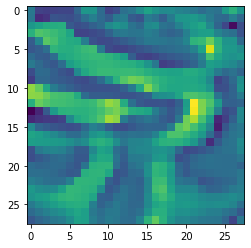

In [52]:
## Let's run our function for 7 and see what image we get.

im = train_im (net, train_loader, digit=7, iters = 10000)
im = np.asarray(im.view(28, 28).cpu().detach())
plt.imshow(im)

In the the following cell we will run the function for all the digits from 0 to 9 and print the outputs 

0


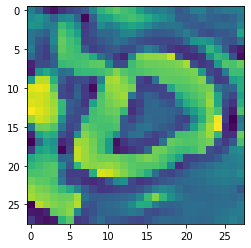

1


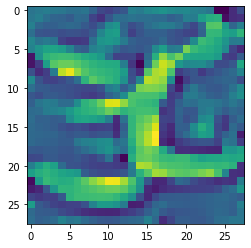

2


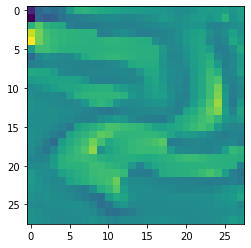

3


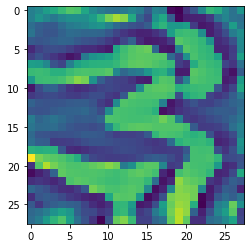

4


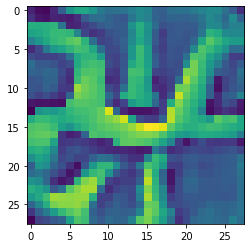

5


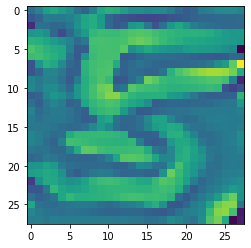

6


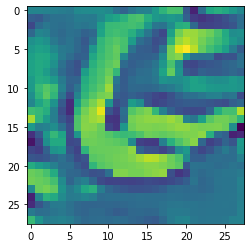

7


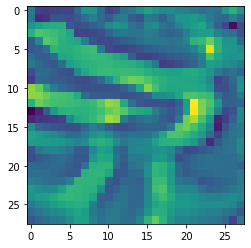

8


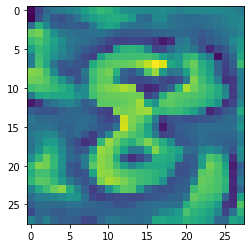

9


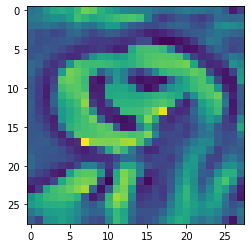

In [53]:
for i in range (10):
    im = train_im (net, train_loader, digit=i, iters=10000)
    im = np.asarray(im.view(28, 28).cpu().detach())
    print (i)
    plt.imshow(im)
    plt.show()

0


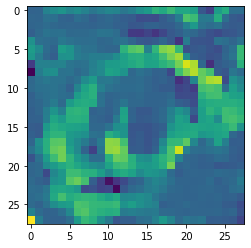

1


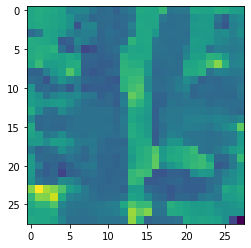

2


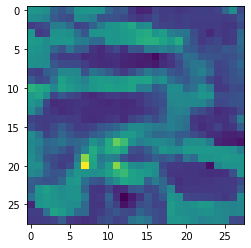

3


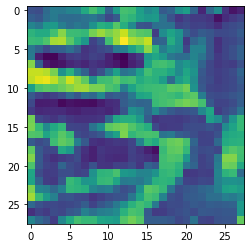

4


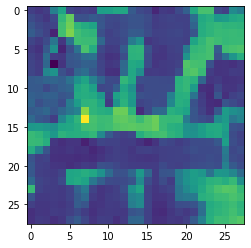

5


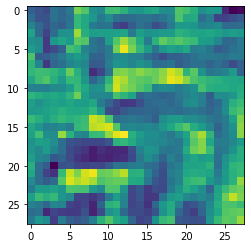

6


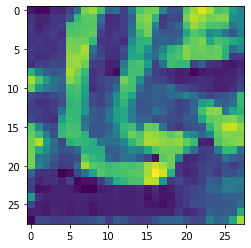

7


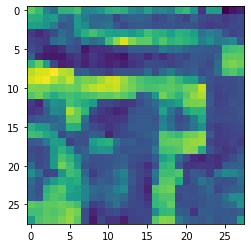

8


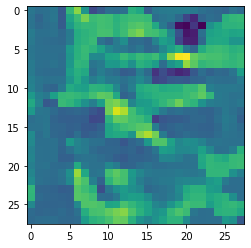

9


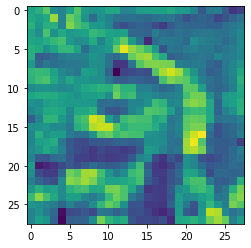

In [56]:
# Same Procedure as above, but with the better performing model. The features learned are not as smooth for the better model imo
for i in range (10):
    im = train_im (net2, train_loader, digit=i, iters=10000)
    im = np.asarray(im.view(28, 28).cpu().detach())
    print (i)
    plt.imshow(im)
    plt.show()